In [0]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()    

Instructions for updating:
non-resource variables are not supported in the long term


In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
import tensorflow as tf
import keras

from keras import backend as K
from keras import losses

from keras.models import Model, Sequential
from keras.objectives import categorical_crossentropy

from keras.layers import Input, concatenate
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, Conv2DTranspose, ZeroPadding2D

from keras.optimizers import Adam, Adadelta, Adamax, Nadam, Adagrad, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback

from keras.initializers import RandomUniform, RandomNormal

Using TensorFlow backend.


In [0]:
import numpy as np
import time
import matplotlib.pyplot as plt 

%matplotlib inline

In [0]:
!pip install dicom

     |████████████████████████████████| 768kB 3.3MB/s 


In [0]:
class PatientData(object):

    """
    
    PatientData looks for files of 3DIRCAD database.
    This database contains DICOM files and data is split into folders.
    PATIENT_DICOM folder contains original original CT Images
    MASKS_DICOM contains a list of several folders. Each folder is named
    according to the organ highlighted in the masks of the files within.
    During PatientData initialization, it will look for the folder pointed at
    root_dir and will load files named with same name on MASKS_DICOM/<organ name>/*
    
    """
    def __init__(self, root_dir, oi, file_extension=".dcm", split_part=0.5):

        import os, re
        patient_images = {}
        import pdb
        
        #iteration = 0
        for root, dirs, files in os.walk(root_dir):
          #for dir in dirs:
            
            for file in files:
                if file.endswith(file_extension):
                    
                    if 'PATIENT_DICOM' in root:
                        #pdb.set_trace()
                        if not patient_images.get(file,None):
                            patient_images[file] = {}
                        p = os.path.join(root,file)
                        patient_images[file]['real'] = p
                        #patient_images[file] = p
                    elif 'MASKS_DICOM' in root:
                        if not patient_images.get(file,None):
                            patient_images[file] = {}
                        p = os.path.join(root,file)
                        rs = re.match('.*MASKS_DICOM/(.*)/.*', str(p))
                        patient_images[file][rs.groups()[0]] = p
                    

       
        self.X = []
        self.Y = []
        
        for k,v in patient_images.items():
            for k1,v1 in v.items():
                if k1 == self.oi:
                    if v.get('real'):
                      self.X.append(v['real'])
                      self.Y.append(v1)
        
        if len(self.X) != len(self.Y):
            raise Exception("number of input images (%d) does not match number of training samples (%d)" % 
                            (len(self.X),len(self.Y)))

        from random import shuffle
            
        self.train_limit = int(len(self.X)*split_part)
        self.indexes = list(range(len(self.X)))
        shuffle(self.indexes)            

        self.X1 = [self.X[c] for c in self.indexes]
        self.Y1 = [self.Y[c] for c in self.indexes]

        self.X1_train = self.X1[0:self.train_limit]
        self.X1_test = self.X1[self.train_limit:]          
        self.Y1_train = self.Y1[0:self.train_limit]
        self.Y1_test = self.Y1[self.train_limit:]         
        
        test_x_path = '/content/drive/My Drive/prediction_images/test_x/'
        test_y_path = '/content/drive/My Drive/prediction_images/test_y/'

        import os, shutil 

        for i in range(len(self.X1_test)):
            shutil.copyfile(self.X1_test[i], test_x_path+'test_x_'+str(i)+'.dcm')
            shutil.copyfile(self.Y1_test[i], test_y_path+'test_y_'+str(i)+'.dcm')
        

            
    def normalize(self, img):
        arr = img.copy().astype(np.float)
        M = np.float(np.max(img))
        if M != 0:
            arr *= 1./M
         
        return arr
    

    def add_gauss_noise(self, inp, expected_noise_ratio=0.05):
        image = inp.copy()
        if len(image.shape) == 2:
            row,col= image.shape
            ch = 1
        else:
            row,col,ch= image.shape
        mean = 0.
        var = 0.1
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col)) * expected_noise_ratio
        gauss = gauss.reshape(row,col)
        noisy = image + gauss
        return noisy

    def get_data(self, noisy=False, resize_side=None, verbose=False):
        from scipy.ndimage.interpolation import zoom        
        import dicom
        
        im_X = []
        im_Y = []
        for i in range(len(self.X)):
            img_x = dicom.read_file(self.X[i]).pixel_array
            img_y = dicom.read_file(self.Y[i]).pixel_array
            if resize_side != None:
                ratio = resize_side / 512.
                img_x = zoom(img_x, ratio).copy()
                img_y = zoom(img_y, ratio).copy()
            img_x = self.normalize(img_x)
            img_y = self.normalize(img_y)
            

            if np.sum(img_y) < 5.:
                if np.random.randint(1,10) <= 5:
                    if verbose:
                        print("discarding a very zero like image %s (%f)" % (self.Y[i],np.sum(img_y)))
                    continue
            if noisy:
                img_x = self.add_gauss_noise(img_x)
                img_y = self.add_gauss_noise(img_y)
            im_X.append(img_x)
            im_Y.append(img_y)
        
        shuffleX = [im_X[c] for c in self.indexes]
        shuffleY = [im_Y[c] for c in self.indexes]
        
        train_x = shuffleX[0:self.train_limit]
        test_x = shuffleX[self.train_limit:]
        train_y = shuffleY[0:self.train_limit]
        test_y = shuffleY[self.train_limit:]
    
        return train_x, train_y, test_x, test_y

In [0]:
root_dir = "/content/drive/My Drive/unet data"

In [0]:
sample_height, sample_width = (512,512)
output_width, output_height = (512, 512)
img_tot_size = sample_width*sample_height

In [0]:
pd = PatientData(root_dir, 'bone', split_part=0.8) #Can work for liver data also

In [0]:
data = pd.get_data(False, sample_width) # Using 80% for training
train_x, train_y, test_x, test_y = map(np.array, data)
print("Using %s images for training and %s images for testing" % (len(train_x), len(test_x)))

In [0]:
lines = min(4,len(train_x))
fig, axarr = plt.subplots(lines, 2, figsize=(15,15), sharex=True, sharey=False)

tot_dice = 0.
for i in range(0,lines):
    
    axarr[i,0].imshow(train_x[i].reshape(output_width, output_height), cmap='gray')
    axarr[i,1].imshow(train_y[i].reshape(output_width, output_height), cmap='gray')
    
    for x in range(2):
        axarr[i,x].axis('off')

fig.tight_layout()
fig.subplots_adjust(top=0.975)
plt.show()

In [0]:
train_x = np.array([t.reshape(sample_width, sample_height,1) for t in train_x])
train_y = np.array([t.reshape(sample_width, sample_height,1) for t in train_y])
test_x  = np.array([t.reshape(sample_width, sample_height,1) for t in test_x])
test_y  = np.array([t.reshape(sample_width, sample_height,1) for t in test_y])


In [0]:
def get_model(optimizer, loss_metric, metrics, lr=1e-3):
    inputs = Input((sample_width, sample_height, 1))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    drop1 = Dropout(0.5)(pool1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(drop1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    drop2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(drop2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    drop3 = Dropout(0.3)(pool3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(drop3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    drop4 = Dropout(0.3)(pool4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(drop4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    # working with dice and adam
    model.compile(optimizer=Adam(lr=1e-3, decay=1e-3), loss=dice_coef_loss, metrics=[dice_coef])
  
    
    return model

In [0]:
smooth = 1.

# Dice Coefficient to work with Tensorflow
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

# Dice Coefficient to work outside Tensorflow
def dice_coef_2(y_true, y_pred):
    side = len(y_true[0])
    y_true_f = y_true.reshape(side*side)
    y_pred_f = y_pred.reshape(side*side)
    intersection = sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (sum(y_true_f) + sum(y_pred_f) + smooth)

In [0]:
model = get_model(optimizer=Adam, loss_metric=dice_coef_loss, metrics=[dice_coef], lr=1e-3)

In [0]:
observe_var = 'dice_coef'
strategy = 'max'

In [0]:
start_time = time.time()

history = model.fit(train_x, train_y, batch_size=16,
          epochs=100, verbose=1, shuffle=True, validation_data=(test_x,test_y))


elapsed_time = time.time() - start_time
print("Elapsed time: ", elapsed_time)

In [0]:
model_save_name = 'classifier_final1.pt'
path = F"/content/drive/My Drive/{model_save_name}"
model.save_weights(path)

In [0]:
print(history.history.keys())

dict_keys(['val_loss', 'val_dice_coef', 'loss', 'dice_coef'])


In [0]:
plt.plot(history.history['dice_coef'])
plt.title('Model Accuracy')
plt.ylabel('Dice Coef.')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
imgs_mask_test = model.predict(test_x, verbose=1)

tot_dice = 0.
dices = []
for i in range(len(imgs_mask_test)):
    r = dice_coef_2(test_y[i],imgs_mask_test[i])
    dices.append(r)
    tot_dice += r
    
avg_dice = tot_dice/float(len(imgs_mask_test))
print(avg_dice)

465/465 [==============================] - 9s 20ms/step
0.9258228555026184


In [0]:
postProcess = True
if postProcess:        
    avg = np.average(imgs_mask_test)
    for k in range(len(imgs_mask_test)):
        im = imgs_mask_test[k]
        m = np.max(im)
        for i in range(len(im)):
            for j in range(len(im[i])):
                # remove low confidence results helps to increase dice result
                if im[i,j] < (0.5):
                    im[i,j] = 0.
    
    tot_dice = 0.
    dices = []
    for i in range(len(imgs_mask_test)):
        r = dice_coef_2(test_y[i],imgs_mask_test[i])
        dices.append(r)
        tot_dice += r
        

    avg_dice = tot_dice/float(len(imgs_mask_test))
    print(avg_dice)

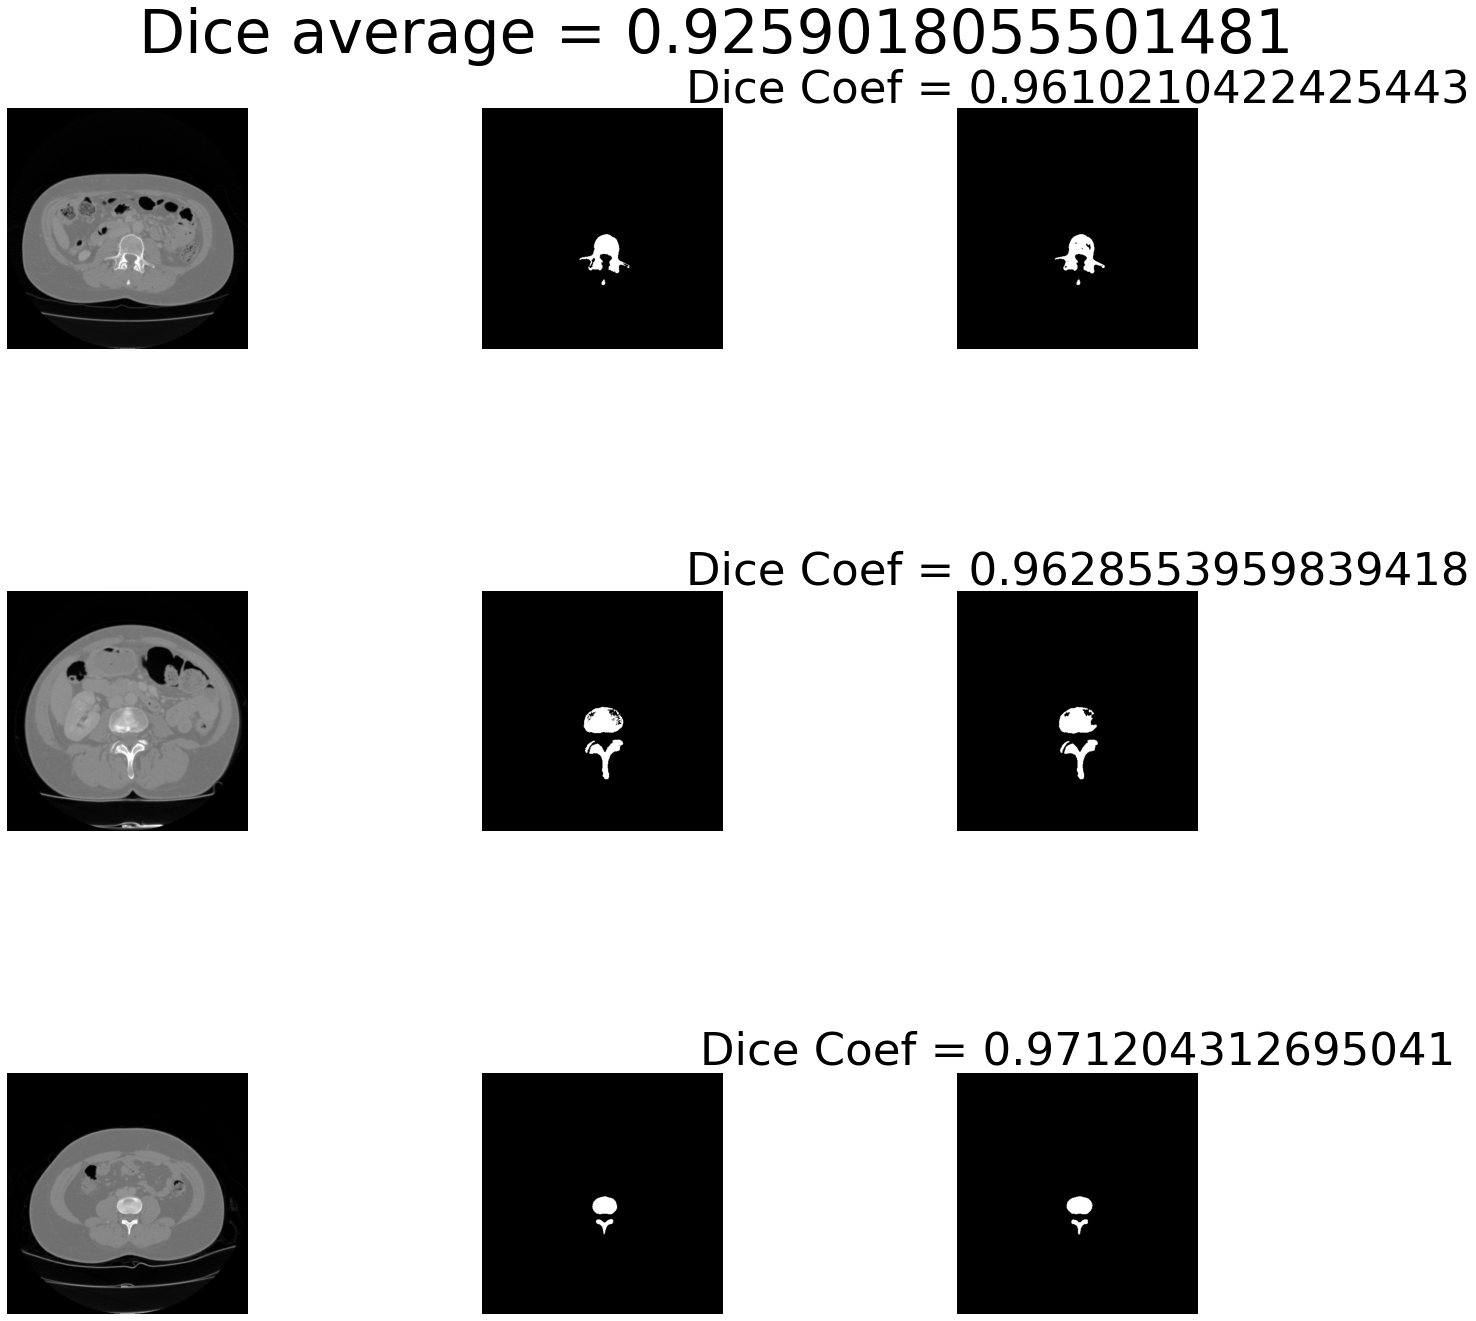

In [0]:
fig, axarr = plt.subplots(3, 3, figsize=(20,20), sharex=True, sharey=False)

output_width, output_height = (512, 512)
for i in range(0,3):
    axarr[i,0].imshow(test_x[i].reshape(output_width, output_height), cmap='gray')
    axarr[i,1].imshow(test_y[i].reshape(output_width, output_height), cmap='gray')
    axarr[i,2].imshow(imgs_mask_test[i].reshape(output_width, output_height), cmap='gray')
    axarr[i,2].set_title('Dice Coef = ' + str(dices[i]),fontsize=45,ha='center')
    
    for x in range(3):
        axarr[i,x].axis('off')

fig.suptitle('Dice average = ' + str(avg_dice) ,fontsize=60)
fig.tight_layout()
fig.subplots_adjust(top=0.975)
plt.show()